In [2]:
# Basic Function
import numpy as np
# linear algebra /advanced mathematical and other types of operations on large numbers of data
import pandas as pd
# data processing, CSV file I/O (e.g. pd.read_csv)/data manipulation and analysis
import os
#The OS module in Python provides functions for interacting with the operating system
import matplotlib.pyplot as plt
#Pyplot is a collection of functions in the popular visualization package
#such as creating a figure, creating a plotting area, plotting lines, adding plot labels
import cv2
#OpenCV is a cross-platform library using which we can develop real-time computer vision applications. 
#It mainly focuses on image processing, video capture and analysis including features like face detection and object detection.


In [3]:
# Keras Function
# Tensorflow : data flow graphs to build model. Allow developers to create large-scale neural networks with many layers. 
# TensorFlow is mainly used for: Classification, Perception, Understanding, Discovering, Prediction 
#KERAS : provides a Python interface for artificial neural networks.Keras acts as an interface for the TensorFlow library.
from keras_preprocessing.image import ImageDataGenerator
# ImageDataGenerator Generate batches with real-time data augmentation.
from keras.models import Model
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
# Flatten : Flatten will take a tensor of any shape and transform it into a one dimensional tensor
#GlobalAveragePooling2D : Average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged
from keras.preprocessing import image
#The models are used to define TensorFlow neural networks by specifying the attributes, functions, and layers you want

In [4]:
# Trasfer Learning Model: InceptionV3
from keras.applications.inception_v3 import InceptionV3

In [5]:
#loading in the csv data
df = pd.read_csv('D:/OneDrive - Perfetti Van Melle/IPBA-IIM Indore/Project/train.csv',error_bad_lines=False)
#Lines with too many fields (e.g. a csv line with too many commas) will by default cause an exception to be raised no DataFrame will be returned.
#If False, then these “bad lines” will dropped from the DataFrame that is returned.
fashion_dir = 'D:\\OneDrive - Perfetti Van Melle\\IPBA-IIM Indore\\Project\\fashion'
df.head()
#print(df)

,files,target,images
0,../input/fashiondata/data/shoes/5da81ceb7861c2...,shoes,5da81ceb7861c2af6a5a89a7_1.jpg
1,../input/fashiondata/data/beauty/5da81d8a7861c...,beauty,5da81d8a7861c2af6a5a901c_3.jpg
2,../input/fashiondata/data/beauty/5da820f26504f...,beauty,5da820f26504fb65da0043e6_0.jpg
3,../input/fashiondata/data/jewelry and watches/...,jewelry and watches,5da81c026504fb65cea700d2_0.jpg
4,../input/fashiondata/data/bags/5da81d2c7861c2a...,bags,5da81d2c7861c2af6a5a8c64_2.jpg


5da81ceb7861c2af6a5a89a7_1.jpg


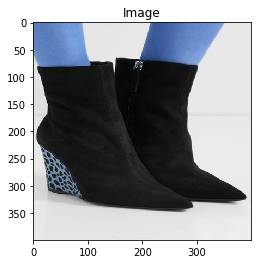

5da81d8a7861c2af6a5a901c_3.jpg


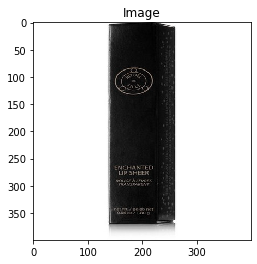

5da820f26504fb65da0043e6_0.jpg


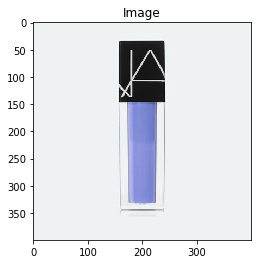

5da81c026504fb65cea700d2_0.jpg


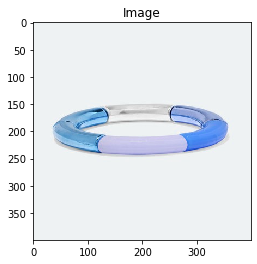

5da81d2c7861c2af6a5a8c64_2.jpg


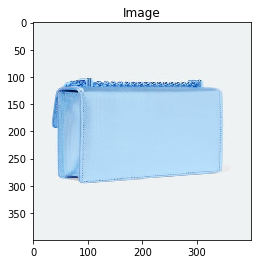

In [6]:
# Loading the image
for i in df.images[0:5]:
    print(i)
    imageName = 'D:\\OneDrive - Perfetti Van Melle\\IPBA-IIM Indore\\Project\\fashion\\'+ i
    image = cv2.imread(imageName) 
    plt.imshow(image)
    plt.title('Image')
    plt.show()
    
df.nunique() # unique image
df.columns
batch_size = 32

In [7]:
# Preprocessing the images and split into trainig & validation data set
train_generator = ImageDataGenerator(
    validation_split=0.20,
    rescale=1.0/255.0,
     horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    validation_split=0.20,
    rescale = 1./255)

training_set = train_generator.flow_from_dataframe(
    dataframe=df,
    directory=fashion_dir,
    x_col="images",
    y_col="target",
    target_size=(299,299),  # InceptionV3 read 299 by 299 size
    batch_size=batch_size,
    class_mode = 'categorical',
    subset="training"
)

test_set = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=fashion_dir,
    x_col="images",
    y_col="target",
    target_size=(299,299),
    batch_size=batch_size,
    class_mode = 'categorical',
    subset="validation"
)

Found 4800 validated image filenames belonging to 4 classes.
Found 1200 validated image filenames belonging to 4 classes.


In [8]:
classes = len(training_set.class_indices)   # Number of category present in dataset
classes

4

In [9]:
# creating based model with help of pretrained InceptionV3 model
from keras.applications.inception_v3 import InceptionV3
IMAGE_SIZE = [299, 299]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False) 
# [3] means added number of channel (RGB) it is colour image
# weights present in Kera
#include_top: whether to include the fully-connected layer at the top of the network.
#we will not train existing weights

In [10]:
# train only the top layers
for layer in inception.layers:  # don't need to trainas weight are fixed
    layer.trainable = False     # false means model already being trained
x = Flatten()(inception.output) # flattening the last layer
prediction = Dense(classes, activation='softmax')(x)
print(prediction)
#The activation function to use on the "top" layer . softmax for logistic layer 
# this is the model we will train

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [12]:
# this is the model we will train
model = Model(inputs=inception.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [13]:
# compile the model.setting layers to non-trainable
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Fit the model for a few epochs
r=model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
150/150 [==============================] - 625s 4s/step - loss: 5.3943 - accuracy: 0.8038 - val_loss: 1.2180 - val_accuracy: 0.9442
Epoch 2/20
150/150 [==============================] - 542s 4s/step - loss: 0.8987 - accuracy: 0.9513 - val_loss: 2.2419 - val_accuracy: 0.9258
Epoch 3/20
150/150 [==============================] - 531s 4s/step - loss: 0.7127 - accuracy: 0.9645 - val_loss: 3.7595 - val_accuracy: 0.9017
Epoch 4/20
150/150 [==============================] - 506s 3s/step - loss: 0.4789 - accuracy: 0.9781 - val_loss: 1.5323 - val_accuracy: 0.9475
Epoch 5/20
150/150 [==============================] - 501s 3s/step - loss: 0.1973 - accuracy: 0.9884 - val_loss: 1.7309 - val_accuracy: 0.9558
Epoch 6/20
150/150 [==============================] - 506s 3s/step - loss: 0.2733 - accuracy: 0.9881 - val_loss: 1.3432 - val_accuracy: 0.9567
Epoch 7/20
150/150 [==============================] - 505s 3s/step - loss: 0.1826 - accuracy: 0.9898 - val_loss: 0.9323 - val_accuracy: 0.9717

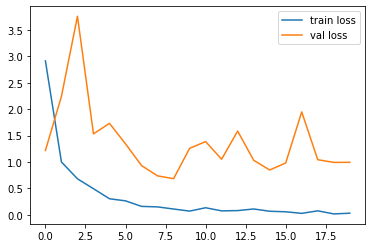

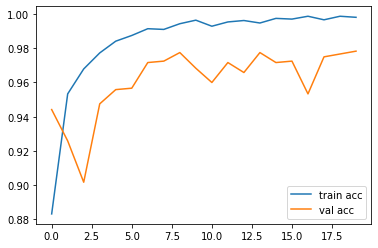

<Figure size 432x288 with 0 Axes>

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
# reading outside image
data_dir="D:\\OneDrive - Perfetti Van Melle\\IPBA-IIM Indore\\Project"
os.chdir(data_dir)
#img=cv2.imread("bag1.jfif") 
#img=cv2.imread("Jewellery1.jfif")  
#img=cv2.imread("beauti1.jpg")  
img=cv2.imread("Shoes1.jpg")  
type(img)  #numpy.ndarray
img.shape



(319, 500, 3)

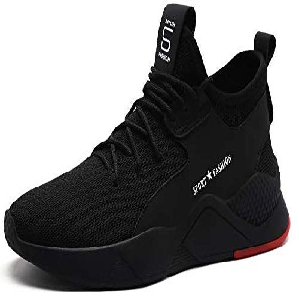

In [25]:
from keras.preprocessing import image
#file_name = 'bag1.jfif'
#file_name = 'Jewellery1.jfif'
#file_name = 'beauti1.jpg'
file_name = 'Shoes1.jpg'
img = image.load_img(file_name, target_size=(299, 299))
img

In [26]:
img1 = image.img_to_array(img)
img1.shape


(299, 299, 3)

In [27]:
img1=img1/255

In [28]:
x=np.expand_dims(img1,axis=0)
x.shape

(1, 299, 299, 3)

In [29]:
print(model.predict(x))

[[0. 0. 0. 1.]]


In [30]:
preds = model.predict(x)
preds=np.argmax(preds, axis=1)
print(preds)


[3]


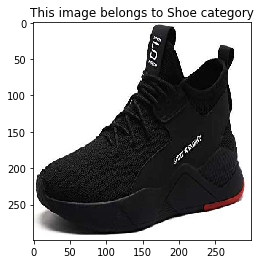

In [31]:
# Predict the category of any image
preds = model.predict(x)
preds=np.argmax(preds, axis=1)
print(preds)

if preds==0:
        preds="This image belongs to bag category"
elif preds==1:
    preds="This image belongs to Beauty category"
elif preds==2:
    preds="This image belongs Jewellery and watches category"
else:
    preds="This image belongs Shoes category"
#print(preds)
plt.title(preds)
plt.imshow(img)
